In [59]:
import numpy as np
from trimesh import Trimesh
import pandas as pd
import SimpleITK as sitk
import os

VOXEL_SIZE = 1.0

def extract_subpart(points, faces, ids, subpartID):
    # points: points
    # faces: faces
    # ids: IDs to extract
    # subpartID: list of IDs for every point

    ids = [ids] if not isinstance(ids, list) else ids
    
    n_points = len(points)
    new_points = []
    point_ids = []

    for i in range(points.shape[0]):
        for id_ in ids:
            if id_ in subpartID[i]:
                new_points.append(points[i])
                point_ids.append(i)
                break

    points = np.array(new_points)

    point_ids_set = set(point_ids)
    triangles = [
        tuple(triangle)
        for triangle in faces
        if all([pp in point_ids_set for pp in triangle])
    ]

    id_mapping = {x: i for i, x in enumerate(point_ids)}
    triangles = np.array(
        [tuple([id_mapping[x] for x in triangle]) for triangle in triangles]
    )
    
    return points, triangles


def to_matrix_vector(transform):
    ndimin = transform.shape[0] - 1
    ndimout = transform.shape[1] - 1
    matrix = transform[0:ndimin, 0:ndimout]
    vector = transform[0:ndimin, ndimout]
    return matrix, vector

def get_mask_image_2CH(masked_fhm, grilla, lax, pid, Origin):
    # output mask
    mask_img = 0 * np.ones((lax.height, lax.width, lax.num_slices), dtype=np.uint8)

    # get slice index for z direction
    slice_idx = [0]

    # create image grid
    xr = np.arange(0, mask_img.shape[1], dtype=float)
    yr = np.arange(0, mask_img.shape[0], dtype=float)
    xs, ys = np.meshgrid(xr, yr)

    df = pd.read_csv('./csv/params_2CH.csv', index_col=False)
    matrix = df[(df["case_id"] == int(pid))].to_dict('list')
   
    M, b = to_matrix_vector(np.fromstring(str(matrix['trans'][0])[1:-1], dtype=float, sep=',').reshape(
                                      4, 4))

    for i, si in enumerate(slice_idx):
        pos = np.stack([xs.flatten(), ys.flatten(), si * np.ones(len(xs.flatten()))], axis=1)

        mapped_pos = []
        for index in range(len(pos)):
            
            p = pos[index]
            p_ = np.array([p[0], p[1], p[2]])
            new_p = np.dot(M, p_) + b
            new_p_ = np.array([new_p[0] * lax.spacing[0] + Origin[0], new_p[1] * lax.spacing[1] + Origin[1], new_p[2] * 10 + Origin[2]])
            mapped_pos.append(new_p_)
            
        pos = np.array(mapped_pos)
        values = get_mask_values(masked_fhm, grilla, pos)
        mask_img[:, :, i] = values.reshape(lax.height, lax.width)

    return mask_img


def get_mask_image_4CH(masked_fhm, grilla, lax, pid, Origin):
    # output mask
    mask_img = 0 * np.ones((lax.height, lax.width, lax.num_slices), dtype=np.uint8)

    # get slice index for z direction
    slice_idx = [0]

    # create image grid
    xr = np.arange(0, mask_img.shape[1], dtype=float)
    yr = np.arange(0, mask_img.shape[0], dtype=float)
    xs, ys = np.meshgrid(xr, yr)
   
    df = pd.read_csv('./csv/params_4CH.csv', index_col=False)
    matrix = df[(df["case_id"] == int(pid))].to_dict('list')
   
    M, b = to_matrix_vector(np.fromstring(str(matrix['trans'][0])[1:-1], dtype=float, sep=',').reshape(
                                      4, 4))

    for i, si in enumerate(slice_idx):
        
        pos = np.stack([xs.flatten(), ys.flatten(), si * np.ones(len(xs.flatten()))], axis=1)

        mapped_pos = []
        for index in range(len(pos)):
            
            p = pos[index]
            p_ = np.array([p[0], p[1], p[2]])
            new_p = np.dot(M, p_) + b
            new_p_ = np.array([new_p[0] * lax.spacing[0] + Origin[0], new_p[1] * lax.spacing[1] + Origin[1], new_p[2] * 10 + Origin[2]])
            mapped_pos.append(new_p_)
        pos = np.array(mapped_pos)
        values = get_mask_values(masked_fhm, grilla, pos)
        mask_img[:, :, i] = values.reshape(lax.height, lax.width)

    return mask_img


def get_grid(label, faces, subs):
    full_mesh = get_tmesh(label.copy(), faces, ["RA", "LA"], subs)

    VX_BG = 0
    VX_LA = 50
    VX_RA = 100

    grilla = np.zeros(full_mesh.shape, dtype=np.uint8)
    grilla.shape

    ra = get_tmesh(label.copy(), faces, ["RA"], subs)
    la = get_tmesh(label.copy(), faces, ["LA"], subs)

    grilla[full_mesh.matrix] = 10
    grilla = assign_voxels(grilla, la, 50, full_mesh)
    grilla = assign_voxels(grilla, ra, 100, full_mesh)

    return full_mesh, grilla

def assign_voxels(grid, mesh, value, full):
        """
        Internal method. Don't use it directly.
        """
        # get the _grid and indices where voxels are true
        xs, ys, zs = np.meshgrid(range(mesh.shape[0]), range(mesh.shape[1]), range(mesh.shape[2]), indexing='ij')
        xs = xs[mesh.matrix]
        ys = ys[mesh.matrix]
        zs = zs[mesh.matrix]

        # convert those indices into point coordinates
        mesh_pts = mesh.indices_to_points(np.stack([xs, ys, zs]).transpose())

        # using main voxel_grid to get the indices inside rvlv
        fhm_idx = full.points_to_indices(mesh_pts)

        # assign value
        grid[fhm_idx[:, 0], fhm_idx[:, 1], fhm_idx[:, 2]] = value

        return grid

def get_tmesh(v, f, subpartID, subpart_ids):
    v, f = extract_subpart(v.copy(), f, subpartID, subpart_ids)
    return Trimesh(vertices=v, faces=f).voxelized(VOXEL_SIZE).fill()

def get_mask_values(fhm, grilla, pos, outbound=0):
    # get valid indices
    indices = fhm.points_to_indices(pos)

    j = (0 <= indices[:, 0]) & (indices[:, 0] < grilla.shape[0]) & \
        (0 <= indices[:, 1]) & (indices[:, 1] < grilla.shape[1]) & \
        (0 <= indices[:, 2]) & (indices[:, 2] < grilla.shape[2])
        
    values = outbound * np.ones(pos.shape[0], dtype=np.uint8)
    values[j] = grilla[indices[j, 0], indices[j, 1], indices[j, 2]]

    return values

def save_nii(filename, data,spacing):
    dataITK = sitk.GetImageFromArray(data) 
    dataITK.SetSpacing(spacing)   
    sitk.WriteImage(dataITK, filename)

In [60]:
from utils.SaxImage import SAXImage
from utils.LaxImage import LAXImage
import numpy as np

subject_id = "1038548"
time_id = "time021"

subject = "../Dataset/Subjects/" + subject_id + "/image/" + time_id

SAX_PATH = os.path.join(subject, "SAX")
LAX_PATH = os.path.join(subject, "LAX")
LAX_2CH_PATH = os.path.join(LAX_PATH, "2CH", '0001')
LAX_3CH_PATH = os.path.join(LAX_PATH, "3CH", '0001')
LAX_4CH_PATH = os.path.join(LAX_PATH, "4CH", '0001')

SaxImage = SAXImage(SAX_PATH)
Lax2CH = LAXImage(LAX_2CH_PATH)
Lax4CH = LAXImage(LAX_4CH_PATH)

direction_matrix = np.array(SaxImage.direction).reshape(3, 3)
inverse_direction_matrix = np.linalg.inv(direction_matrix)

#points = np.load("/home/ngaggion/Documentos/3D/Leeds/Dataset/Subjects/" + subject_id + "/mesh/" + time_id + "/surface.npy")
#points = np.dot((points - SaxImage.origin), inverse_direction_matrix.T) + SaxImage.origin
points = np.load("/home/ngaggion/Documentos/3D/Leeds/Predictions/Surface/ROI_WDS_1_WL_0.01_3D_32_2D_8_KL_1e-5/Meshes/" + subject_id + "/" + time_id + "/mesh.npy")


faces = np.load("../Dataset/SurfaceFiles/faces_fhm_numpy.npy")
subs = np.loadtxt("../Dataset/SurfaceFiles/subparts_fhm.txt", dtype=str)

fmesh, grilla = get_grid(points, faces, subs)
img2ch = get_mask_image_2CH(fmesh, grilla, Lax2CH, subject_id, SaxImage.origin)
img4ch = get_mask_image_4CH(fmesh, grilla, Lax4CH, subject_id, SaxImage.origin)

In [61]:
Lax2CH.spacing

(1.8269230127335, 1.8269230127335)

In [62]:
Lax4CH.spacing

(1.8269231319427, 1.8269231319427)

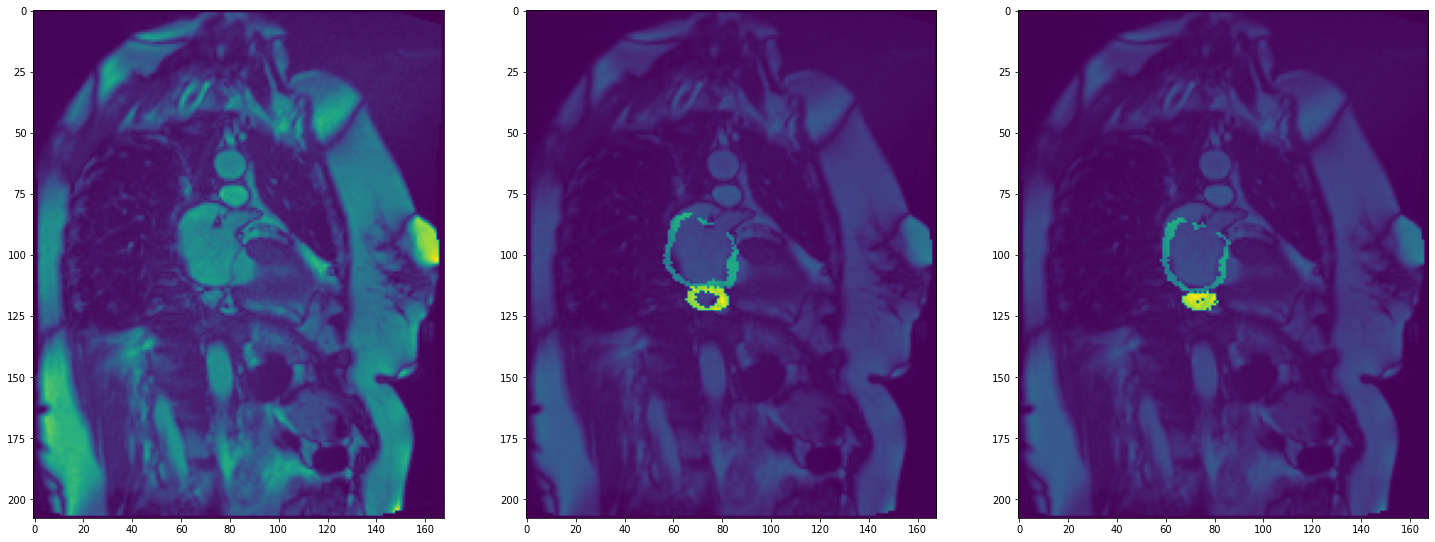

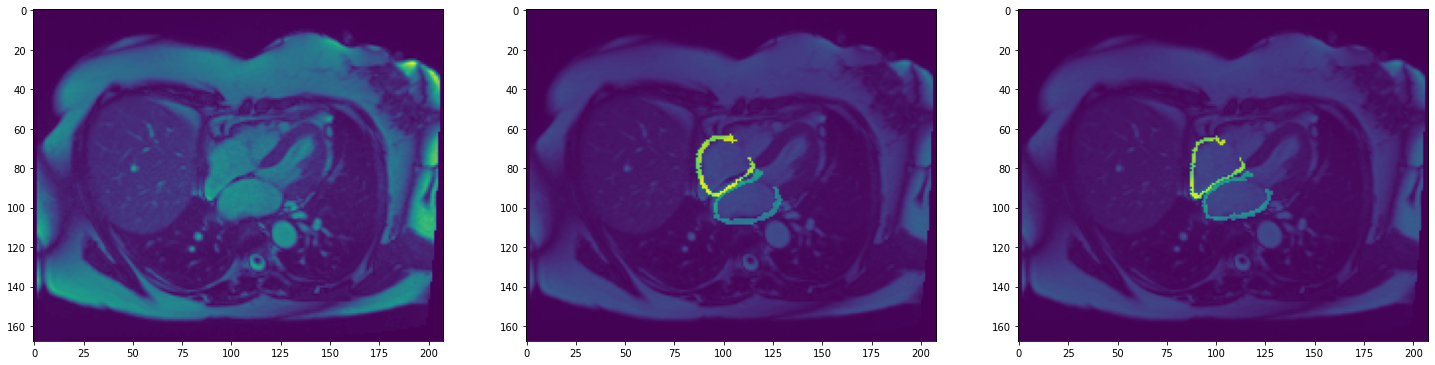

In [63]:
import matplotlib.pyplot as plt
import SimpleITK as sitk

path_2ch = "/home/ngaggion/Documentos/3D/Leeds/Dataset/LaxMasksYan/mask_2CH/1038548_time021_gt.nii.gz"
path_4ch = "/home/ngaggion/Documentos/3D/Leeds/Dataset/LaxMasksYan/mask_4CH/1038548_time021_gt.nii.gz"

path2ch = sitk.GetArrayFromImage(sitk.ReadImage(path_2ch))
path4ch = sitk.GetArrayFromImage(sitk.ReadImage(path_4ch))
            
plt.figure(figsize=(25, 10))
plt.subplot(1,3,1)
plt.imshow(Lax2CH.pixel_array()[:, :, 0]) 
plt.subplot(1,3,2)
plt.imshow(np.clip(Lax2CH.pixel_array()[:, :, 0]/10 + img2ch[:, :, 0] , a_min=0, a_max=255))
plt.subplot(1,3,3)
plt.imshow(np.clip(Lax2CH.pixel_array()[:, :, 0]/10 + path2ch[0, :, :] , a_min=0, a_max=255))


plt.figure(figsize=(25, 10))
plt.subplot(1,3,1)
plt.imshow(Lax4CH.pixel_array()[:, :, 0]) 
plt.subplot(1,3,2)
plt.imshow(np.clip(Lax4CH.pixel_array()[:, :, 0]/10 + img4ch[:, :, 0] , a_min=0, a_max=255))
plt.subplot(1,3,3)
plt.imshow(np.clip(Lax4CH.pixel_array()[:, :, 0]/10 + path4ch[0, :, :] , a_min=0, a_max=255))

In [64]:
from medpy.metric import dc
import cv2 

def MCD(seg_A, seg_B):
    table_md = []
    seg_A = seg_A.transpose(2,1,0)
    seg_B = seg_B.transpose(2,1,0)
    seg_A[seg_A>0] = 1
    seg_B[seg_B>0] = 1
    
    X, Y, Z = seg_A.shape
    for z in range(Z):
        # Binary mask at this slice
        slice_A = seg_A[:, :, z].astype(np.uint8)
        slice_B = seg_B[:, :, z].astype(np.uint8)

        if np.sum(slice_A) > 0 and np.sum(slice_B) > 0:
            contours, _ = cv2.findContours(cv2.inRange(slice_A, 1, 1),
                                              cv2.RETR_EXTERNAL,
                                              cv2.CHAIN_APPROX_NONE)
            pts_A = contours[0]
            for i in range(1, len(contours)):
                pts_A = np.vstack((pts_A, contours[i]))

            contours, _ = cv2.findContours(cv2.inRange(slice_B, 1, 1),
                                              cv2.RETR_EXTERNAL,
                                              cv2.CHAIN_APPROX_NONE)
            pts_B = contours[0]
            for i in range(1, len(contours)):
                pts_B = np.vstack((pts_B, contours[i]))
            # Distance matrix between point sets
            M = np.zeros((len(pts_A), len(pts_B)))
            for i in range(len(pts_A)):
                for j in range(len(pts_B)):
                    M[i, j] = np.linalg.norm(pts_A[i, 0] - pts_B[j, 0])

     
            md = 0.5 * (np.mean(np.min(M, axis=0)) + np.mean(np.min(M, axis=1))) * 1.8
            table_md += [md]

    mean_md = np.mean(table_md) if table_md else None
    return mean_md

def HD(seg_A, seg_B):
    
    table_hd = []
    seg_A = seg_A.transpose(2,1,0)
    seg_B = seg_B.transpose(2,1,0)
    seg_A[seg_A>0] = 1
    seg_B[seg_B>0] = 1
    
    
    X, Y, Z = seg_A.shape
    for z in range(Z):
        # Binary mask at this slice
        slice_A = seg_A[:, :, z].astype(np.uint8)
        slice_B = seg_B[:, :, z].astype(np.uint8)

        if np.sum(slice_A) > 0 and np.sum(slice_B) > 0:
            contours, _ = cv2.findContours(cv2.inRange(slice_A, 1, 1),
                                              cv2.RETR_EXTERNAL,
                                              cv2.CHAIN_APPROX_NONE)
            pts_A = contours[0]
            for i in range(1, len(contours)):
                pts_A = np.vstack((pts_A, contours[i]))

            contours, _ = cv2.findContours(cv2.inRange(slice_B, 1, 1),
                                              cv2.RETR_EXTERNAL,
                                              cv2.CHAIN_APPROX_NONE)
            pts_B = contours[0]
            for i in range(1, len(contours)):
                pts_B = np.vstack((pts_B, contours[i]))

            # Distance matrix between point sets
            M = np.zeros((len(pts_A), len(pts_B)))
            for i in range(len(pts_A)):
                for j in range(len(pts_B)):
                    M[i, j] = np.linalg.norm(pts_A[i, 0] - pts_B[j, 0])

            hd = np.max([np.max(np.min(M, axis=0)), np.max(np.min(M, axis=1))]) * 1.8
            table_hd += [hd]

    mean_hd = np.mean(table_hd) if table_hd else None
    return mean_hd

gt_2CH = sitk.GetArrayFromImage(sitk.ReadImage(path_2ch))
pred2ch = img2ch.transpose(2,0,1)
gt_4CH = sitk.GetArrayFromImage(sitk.ReadImage(path_4ch))
pred4ch = img4ch.transpose(2,0,1)


dice_la2ch = dc(gt_2CH == 50, pred2ch == 50)
hausdorff_la2ch = HD(gt_2CH == 50, pred2ch == 50)
assd_value_la2ch = MCD(gt_2CH == 50, pred2ch == 50)

dice_la4ch = dc(gt_4CH == 50, pred4ch == 50)
hausdorff_la4ch = HD(gt_4CH == 50, pred4ch == 50)
assd_value_la4ch = MCD(gt_4CH == 50, pred4ch == 50)

dice_ra4ch = dc(gt_4CH == 100, pred4ch == 100)
hausdorff_ra4ch = HD(gt_4CH == 100, pred4ch == 100)
assd_value_ra4ch = MCD(gt_4CH == 100, pred4ch == 100)

print(dice_la2ch,dice_la4ch,dice_ra4ch)
print(hausdorff_la2ch,hausdorff_la4ch,hausdorff_ra4ch)
print(assd_value_la2ch,assd_value_la4ch,assd_value_ra4ch)
            

0.44386422976501305 0.27246376811594203 0.41216216216216217
5.4 7.42159012611179 6.48999229583518
1.793617251769596 2.346567927744312 2.0393835640207127
